In [1]:
# Importació de llibreries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go
import plotly.io as pio

# Preprocessament
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import IsolationForest

# Models
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [13]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:

# Carregar dataset
df = pd.read_csv("Conjunt de dades Preprocessades/Datasets/Amazon_Stock_Price_output.csv")

# Assegurar ordre cronològic
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values("Date", inplace=True)

# Definir columnes d'entrada i sortida
FEATURE_COLUMNS = [
    "Open", "High", "Low", "Volume",
    "EMA_7", "EMA_40", "MACD", "Signal_Line",
    "MACD_Hist", "RSI", "ATR"
]
TARGET_COLUMN = "Close"

# Eliminar files amb valors nuls
df.dropna(subset=FEATURE_COLUMNS + [TARGET_COLUMN], inplace=True)

# Extreure matrius X i y
data_X = df[FEATURE_COLUMNS].values
data_y = df[TARGET_COLUMN].values.reshape(-1, 1)

# Funció per crear seqüències temporals
def create_sequences(X, y, n_steps=30):
    Xs, ys = [], []
    for i in range(n_steps, len(X)):
        Xs.append(X[i - n_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

N_STEPS = 30
X_seq, y_seq = create_sequences(data_X, data_y, n_steps=N_STEPS)

# Definir proporcions per a train/val/test (80%/10%/10%)
n_total    = len(X_seq)
train_size = int(n_total * 0.80)
val_size   = int(n_total * 0.10)
test_size  = n_total - train_size - val_size

# Separació temporal
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

# Inicialitzar escaladors
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Escalar les entrades
ns_train, nt, nf = X_train.shape

# Ajustar i transformar X_train
X_train_flat = X_train.reshape(ns_train * nt, nf)
X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(ns_train, nt, nf)

# Transformar X_val
ns_val = X_val.shape[0]
X_val_flat = X_val.reshape(ns_val * nt, nf)
X_val_scaled_flat = scaler_X.transform(X_val_flat)
X_val_scaled = X_val_scaled_flat.reshape(ns_val, nt, nf)

# Transformar X_test
ns_test = X_test.shape[0]
X_test_flat = X_test.reshape(ns_test * nt, nf)
X_test_scaled_flat = scaler_X.transform(X_test_flat)
X_test_scaled = X_test_scaled_flat.reshape(ns_test, nt, nf)

# Escalar les sortides (y)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)


In [3]:
# Funció per generar Data Augmentation
def augment_with_noise(X, y, noise_level=0.01, n_augments=3):
    X_augmented = [X]
    y_augmented = [y]
    for _ in range(n_augments):
        noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
        X_noisy = X + noise
        X_augmented.append(X_noisy)
        y_augmented.append(y)
    X_combined = np.concatenate(X_augmented, axis=0)
    y_combined = np.concatenate(y_augmented, axis=0)
    return X_combined, y_combined

# Aplicar augmentació al conjunt d'entrenament
X_train_scaled, y_train_scaled = augment_with_noise(
    X_train_scaled,
    y_train_scaled,
    noise_level=0.01,
    n_augments=3
)

In [4]:
# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def build_regularized_lstm_model(input_shape, lstm_units=64, dense_units=32, dropout_rate=0.3, learning_rate=0.001, l2_reg=0.001):
    """
    Model LSTM amb regularització L2 i més Dropout per evitar sobreentrenament
    """
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape,
             kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        LSTM(lstm_units // 2, kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


# Inicialitzar LSTM model
lstm_model = build_regularized_lstm_model((N_STEPS, X_train_scaled.shape[2]))

lstm_model.summary()

c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,345 (130.25 KB)

 Trainable params: 33,153 (129.50 KB)

 Non-trainable params: 192 (768.00 B)

In [14]:
callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=0, min_lr=1e-6)
    ]

history = lstm_model.fit(
        X_train_scaled,
        y_train_scaled,
        batch_size=32,
        epochs=50,
        validation_data=(X_val_scaled, y_val_scaled),
        callbacks=callbacks,
        verbose=0
    )

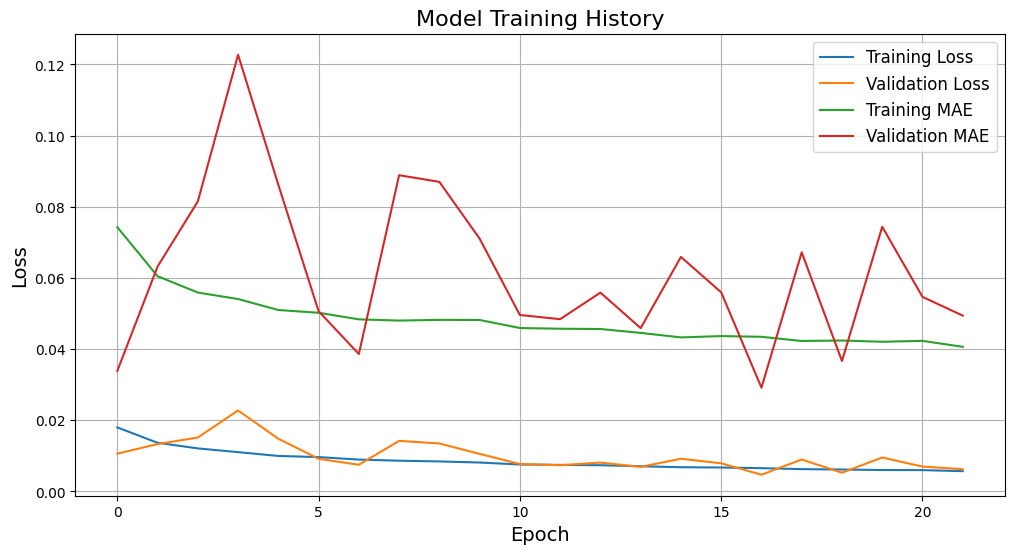

In [15]:
# Representació gràfica de l'historial d'entrenament
def plot_training_history(history):
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    
    plt.title('Model Training History', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_training_history(history)




In [17]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---------------------------------------------------------------------------
# 1) Prediccions LSTM sobre el conjunt d’entrenament (usant dades escalades)
# ---------------------------------------------------------------------------

# 1.1) Predir amb el model LSTM sobre X_train_scaled
#      (X_train_scaled té forma (ns_train, N_STEPS, n_features))
y_pred_lstm_train_scaled = lstm_model.predict(X_train_scaled).flatten()

# 1.2) Invertir l’escala de les prediccions per portar-les a valors reals
#      (scaler_y fou ajustat amb y_train abans)
y_pred_lstm_train = scaler_y.inverse_transform(y_pred_lstm_train_scaled.reshape(-1, 1)).flatten()

# 1.3) Obtenir y_train en la seva escala original
#      (suposem que y_train ja és un array de forma (ns_train, 1) amb valors reals)
y_train_orig = y_train_scaled.flatten()

# 1.4) Calcular residus en l’escala original
residuals_train = y_train_orig - y_pred_lstm_train


# ---------------------------------------------------------------------------
# 2) Preparar dades per a XGBoost (reshape 3D -> 2D)
# ---------------------------------------------------------------------------

# Opció A: usar les característiques escalades (recomanat per coherència)
#           reshape de (ns_train, N_STEPS, n_features) a (ns_train, N_STEPS*n_features)
xgb_X_train = X_train_scaled.reshape(X_train_scaled.shape[0], -1)

# (Si preferiu usar les característiques originals sense escalar:
#  xgb_X_train = X_train.reshape(X_train.shape[0], -1) )


# ---------------------------------------------------------------------------
# 3) Entrenar XGBoost per predir residus
# ---------------------------------------------------------------------------

xgb_residual_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42
)

xgb_residual_model.fit(xgb_X_train, residuals_train)


# ---------------------------------------------------------------------------
# 4) Prediccions híbrides sobre dades de test
# ---------------------------------------------------------------------------

# 4.1) Predicció LSTM sobre X_test_scaled (escala [0,1])
y_pred_lstm_test_scaled = lstm_model.predict(X_test_scaled).flatten()

# 4.2) Invertir escala per obtenir prediccions en valors reals
y_pred_lstm_test = scaler_y.inverse_transform(y_pred_lstm_test_scaled.reshape(-1, 1)).flatten()

# 4.3) Preparar X_test per a XGBoost (mateixa elecció que en entrenament)
xgb_X_test = X_test_scaled.reshape(X_test_scaled.shape[0], -1)

# 4.4) Predicció de residus amb el model XGBoost
residuals_pred_test = xgb_residual_model.predict(xgb_X_test)

# 4.5) Càlcul de la predicció híbrida (LSTM + XGBoost residus)
y_pred_hybrid = y_pred_lstm_test + residuals_pred_test


# ---------------------------------------------------------------------------
# 5) Avaluar el model híbrid
# ---------------------------------------------------------------------------

# Obtenir y_test en forma 1D (escala original)
y_test_orig = y_test.flatten()

mse = mean_squared_error(y_test_orig, y_pred_hybrid)
mae = mean_absolute_error(y_test_orig, y_pred_hybrid)

print(f"Model híbrid LSTM + XGBoost — MSE: {mse:.5f}, MAE: {mae:.5f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model híbrid LSTM + XGBoost — MSE: 35182.07152, MAE: 187.09236


In [18]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Funció per avaluar models amb diverses mètriques
def evaluate_models(y_true, y_pred_lstm, y_pred_hybrid):
    results = []
    
    def calculate_metrics(y_true_arr, y_pred_arr, model_name):
        mse = mean_squared_error(y_true_arr, y_pred_arr)
        mae = mean_absolute_error(y_true_arr, y_pred_arr)
        r2 = r2_score(y_true_arr, y_pred_arr)
        
        return {
            "Model": model_name,
            "MSE": round(mse, 6),
            "MAE": round(mae, 6),
            "R² Score": round(r2, 4)
        }
    
    results.append(calculate_metrics(y_true, y_pred_lstm, "LSTM"))
    results.append(calculate_metrics(y_true, y_pred_hybrid, "Hybrid"))
    
    return pd.DataFrame(results)

# Assegura't d'utilitzar y_test en forma 1D amb valors reals (no escalats):
# Suposem que has fet prèviament:
#   y_test_orig = y_test.flatten()
#   y_pred_lstm_test  = ...  # predicció LSTM en escala real
#   y_pred_hybrid      = ...  # predicció híbrida (LSTM + XGBoost) en escala real

results_df = evaluate_models(y_test_orig, y_pred_lstm_test, y_pred_hybrid)

print("Model Performance Comparison:")
display(results_df)


Model Performance Comparison:


,Model,MSE,MAE,R² Score
0,LSTM,203.421301,10.636015,0.5561
1,Hybrid,35182.071521,187.092359,-75.7736


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Suposem que tens aquestes variables definides:
#   y_test           -> valors reals de tancament (originals, no escalats)
#   y_pred_lstm_test -> prediccions del LSTM (en valors reals, després d'invertir l'escala)
#   y_pred_hybrid    -> prediccions del model híbrid (LSTM + XGBoost) en valors reals

def evaluate_test_set(y_true, y_pred_lstm, y_pred_hybrid):
    results = []
    
    def calc_metrics(y_true_arr, y_pred_arr, model_name):
        mse = mean_squared_error(y_true_arr, y_pred_arr)
        mae = mean_absolute_error(y_true_arr, y_pred_arr)
        r2 = r2_score(y_true_arr, y_pred_arr)
        return {
            "Model": model_name,
            "MSE": round(mse, 6),
            "MAE": round(mae, 6),
            "R2_Score": round(r2, 4)
        }
    
    results.append(calc_metrics(y_true, y_pred_lstm, "LSTM"))
    results.append(calc_metrics(y_true, y_pred_hybrid, "Híbrid"))
    
    return pd.DataFrame(results)

# Calcular les mètriques sobre el conjunt test
test_metrics_df = evaluate_test_set(y_test, y_pred_lstm_test, y_pred_hybrid)

print("Mètriques sobre el conjunt Test:")
display(test_metrics_df)


Mètriques sobre el conjunt Test:


,Model,MSE,MAE,R2_Score
0,LSTM,203.421301,10.636015,0.5561
1,Híbrid,35182.071521,187.092359,-75.7736


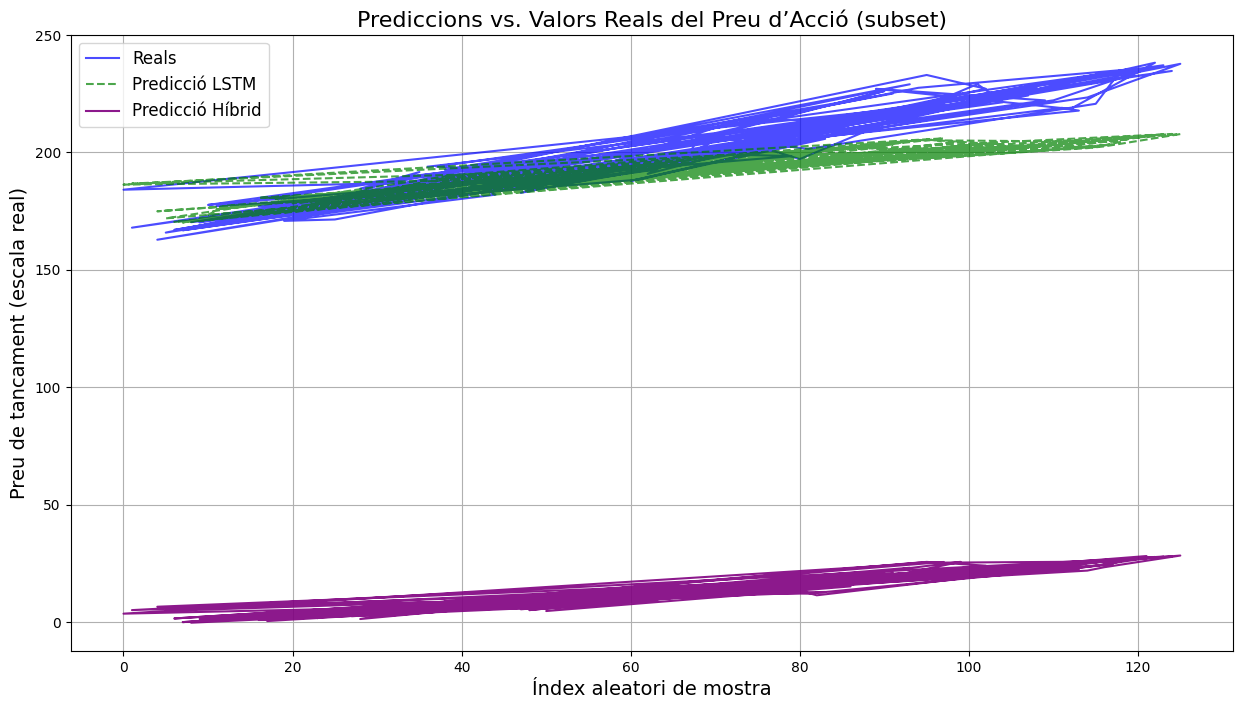

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred_lstm, y_pred_hybrid, n_samples=100):
    """
    Dibuixa una comparació entre els valors reals i les prediccions dels models
    (LSTM pur i híbrid) seleccionant un subset aleatori de mostres (fins a n_samples).
    
    Arguments:
    - y_true: array 1D amb els valors reals del preu (en escala original, no normalitzats).
    - y_pred_lstm: array 1D amb la predicció del model LSTM (en escala original).
    - y_pred_hybrid: array 1D amb la predicció híbrida (LSTM + XGBoost residus) en escala original.
    - n_samples: nombre màxim de punts a mostrar (per evitar grànuls massa densos).
    """
    plt.figure(figsize=(15, 8))
    
    # Seleccionar un conjunt de n_samples índexs aleatoris (sense repetició)
    idx = np.random.choice(len(y_true), size=min(n_samples, len(y_true)), replace=False)
    
    # Dibuixar línies per a cada sèrie de valors
    plt.plot(idx, y_true[idx], label='Reals', color='blue', alpha=0.7)
    plt.plot(idx, y_pred_lstm[idx], label='Predicció LSTM', color='green', linestyle='--', alpha=0.7)
    plt.plot(idx, y_pred_hybrid[idx], label='Predicció Híbrid', color='purple', linestyle='-', alpha=0.9)
    
    plt.title('Prediccions vs. Valors Reals del Preu d’Acció (subset)', fontsize=16)
    plt.xlabel('Índex aleatori de mostra', fontsize=14)
    plt.ylabel('Preu de tancament (escala real)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Exemple d’ús (assegurant-vos que y_test, y_pred_lstm_test i y_pred_hybrid estiguin en escala real):
plot_predictions(y_test_orig, y_pred_lstm_test, y_pred_hybrid)


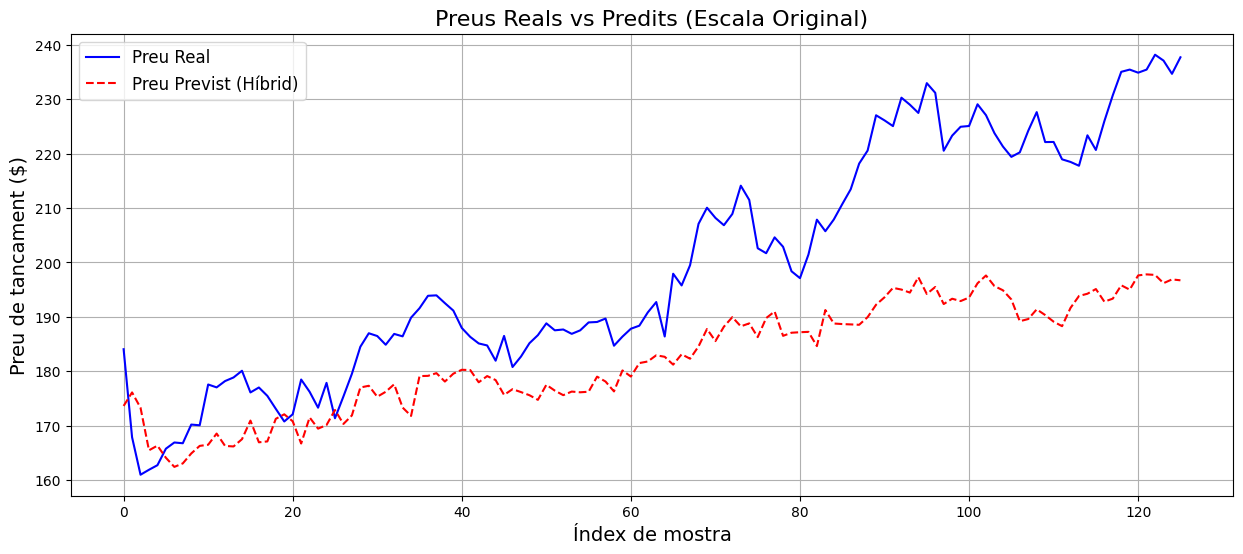

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Nova funció simplificada per invertir l’escala de prediccions de ‘Close’ amb scaler_y
def inverse_transform_close(preds_scaled, scaler_y):
    """
    Preds_scaled: array 1D o 2D amb les prediccions de ‘Close’ en escala [0, 1].
    scaler_y: instància de MinMaxScaler que va ser ajustada només sobre y_train.
    Retorna un array 1D amb els valors en l’escala original de preus.
    """
    preds_2d = preds_scaled.reshape(-1, 1)  # Assegura forma (n, 1)
    return scaler_y.inverse_transform(preds_2d).flatten()


# -------------------------------------------------------
# EXEMPLE D’ÚS amb el vostre pipeline actual:
# -------------------------------------------------------

# Suposem:
#   y_test_scaled       -> array (ns_test, 1) amb y_test ja escalat (input de la xarxa)
#   y_pred_lstm_test_scaled -> array (ns_test, ) o (ns_test, 1) de prediccions LSTM en escala
#   residuals_pred_test     -> array (ns_test, ) de residus predits per XGBoost (ja en unitats reals)
#   scaler_y             -> MinMaxScaler ajustat sobre y_train (column “Close”)

# 1) Invertir l’escala de la predicció LSTM:
y_pred_lstm_test_orig = inverse_transform_close(y_pred_lstm_test_scaled, scaler_y)

# 2) Com que els residus predits ja estan en valors reals (no escalats),
#    la predicció híbrida en escala real és:
y_pred_hybrid_orig = y_pred_lstm_test_orig + residuals_pred_test

# 3) Invertir l’escala de y_test_scaled per obtenir els preus reals de test:
y_test_orig = inverse_transform_close(y_test_scaled, scaler_y)


# -------------------------------------------------------
# Gràfic de comparació entre valors reals i predits (escala original)
# -------------------------------------------------------
plt.figure(figsize=(15, 6))
plt.plot(y_test_orig, label='Preu Real', color='blue')
plt.plot(y_pred_hybrid_orig, label='Preu Previst (Híbrid)', color='red', linestyle='--')
plt.title('Preus Reals vs Predits (Escala Original)', fontsize=16)
plt.xlabel('Índex de mostra', fontsize=14)
plt.ylabel('Preu de tancament ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


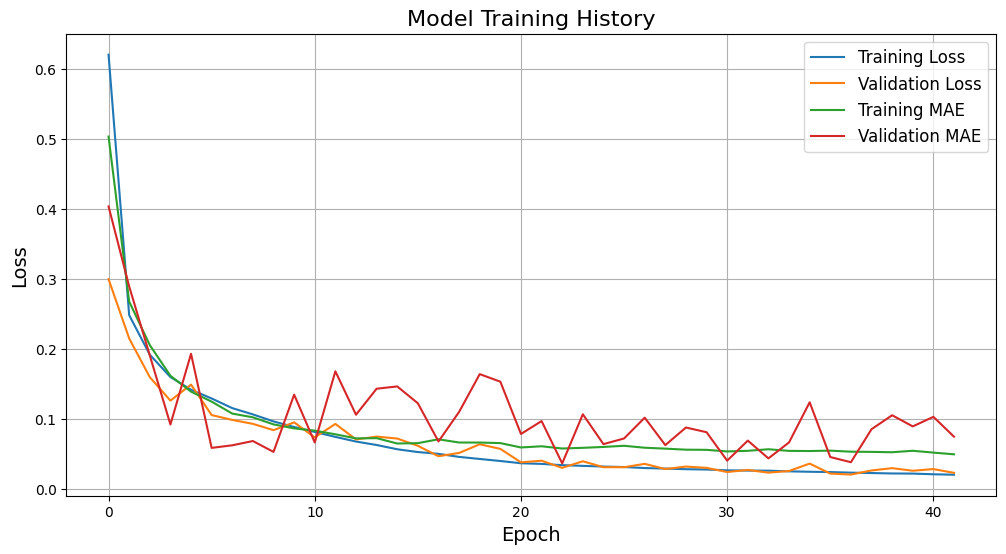

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model Performance Comparison:
    Model         MSE        MAE  R² Score
0    LSTM  247.794545  12.831707    0.4565
1  Hybrid  229.345165  12.528294    0.4969


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# ----------- 1. Carregar i preparar les dades -----------

df = pd.read_csv("Conjunt de dades Preprocessades/Datasets/Amazon_Stock_Price_output.csv")

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values("Date", inplace=True)

FEATURE_COLUMNS = [
    "Open", "High", "Low", "Volume",
    "EMA_7", "EMA_40", "MACD", "Signal_Line",
    "MACD_Hist", "RSI", "ATR"
]
TARGET_COLUMN = "Close"

df.dropna(subset=FEATURE_COLUMNS + [TARGET_COLUMN], inplace=True)

data_X = df[FEATURE_COLUMNS].values
data_y = df[TARGET_COLUMN].values.reshape(-1, 1)

# ----------- 2. Crear seqüències temporals -----------

def create_sequences(X, y, n_steps=20):
    Xs, ys = [], []
    for i in range(n_steps, len(X)):
        Xs.append(X[i - n_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

N_STEPS = 20
X_seq, y_seq = create_sequences(data_X, data_y, n_steps=N_STEPS)

n_total    = len(X_seq)
train_size = int(n_total * 0.80)
val_size   = int(n_total * 0.10)
test_size  = n_total - train_size - val_size

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]
X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

# ----------- 3. Escalat -----------

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Ajustar i transformar X_train
ns_train, nt, nf = X_train.shape
X_train_flat = X_train.reshape(ns_train * nt, nf)
X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(ns_train, nt, nf)

# Transformar X_val i X_test
ns_val = X_val.shape[0]
X_val_flat = X_val.reshape(ns_val * nt, nf)
X_val_scaled_flat = scaler_X.transform(X_val_flat)
X_val_scaled = X_val_scaled_flat.reshape(ns_val, nt, nf)

ns_test = X_test.shape[0]
X_test_flat = X_test.reshape(ns_test * nt, nf)
X_test_scaled_flat = scaler_X.transform(X_test_flat)
X_test_scaled = X_test_scaled_flat.reshape(ns_test, nt, nf)

# Escalar y
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

# ----------- 4. Data Augmentation -----------

def augment_with_noise(X, y, noise_level=0.01, n_augments=3):
    X_augmented = [X]
    y_augmented = [y]
    for _ in range(n_augments):
        noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
        X_noisy = X + noise
        X_augmented.append(X_noisy)
        y_augmented.append(y)
    X_combined = np.concatenate(X_augmented, axis=0)
    y_combined = np.concatenate(y_augmented, axis=0)
    return X_combined, y_combined

X_train_scaled, y_train_scaled = augment_with_noise(
    X_train_scaled,
    y_train_scaled,
    noise_level=0.01,
    n_augments=3
)

# ----------- 5. Model LSTM -----------

def build_regularized_lstm_model(input_shape, lstm_units=64, dense_units=32, dropout_rate=0.3, learning_rate=0.001, l2_reg=0.001):
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

lstm_model = build_regularized_lstm_model((N_STEPS, X_train_scaled.shape[2]))

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=0, min_lr=1e-6)
]

history = lstm_model.fit(
    X_train_scaled,
    y_train_scaled,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=callbacks,
    verbose=0
)

# ----------- 6. Representació gràfica de l'historial d'entrenament -----------

def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Training History', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_training_history(history)

# ----------- 7. Prediccions LSTM i XGBoost (Hybrid) -----------

# Predicció LSTM sobre train
y_pred_lstm_train_scaled = lstm_model.predict(X_train_scaled).flatten()
y_pred_lstm_train = scaler_y.inverse_transform(y_pred_lstm_train_scaled.reshape(-1, 1)).flatten()
y_train_real = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()

# Residus
residuals_train = y_train_real - y_pred_lstm_train

# Dades per XGBoost: reshape 3D -> 2D
xgb_X_train = X_train_scaled.reshape(X_train_scaled.shape[0], -1)

# Model de residus XGBoost
xgb_residual_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42
)
xgb_residual_model.fit(xgb_X_train, residuals_train)

# Predicció sobre test
y_pred_lstm_test_scaled = lstm_model.predict(X_test_scaled).flatten()
y_pred_lstm_test = scaler_y.inverse_transform(y_pred_lstm_test_scaled.reshape(-1, 1)).flatten()

xgb_X_test = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
residuals_pred_test = xgb_residual_model.predict(xgb_X_test)

y_pred_hybrid = y_pred_lstm_test + residuals_pred_test

y_test_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# ----------- 8. Avaluació -----------

def evaluate_models(y_true, y_pred_lstm, y_pred_hybrid):
    results = []
    def calculate_metrics(y_true_arr, y_pred_arr, model_name):
        mse = mean_squared_error(y_true_arr, y_pred_arr)
        mae = mean_absolute_error(y_true_arr, y_pred_arr)
        r2 = r2_score(y_true_arr, y_pred_arr)
        return {
            "Model": model_name,
            "MSE": round(mse, 6),
            "MAE": round(mae, 6),
            "R² Score": round(r2, 4)
        }
    results.append(calculate_metrics(y_true, y_pred_lstm, "LSTM"))
    results.append(calculate_metrics(y_true, y_pred_hybrid, "Hybrid"))
    return pd.DataFrame(results)

results_df = evaluate_models(y_test_real, y_pred_lstm_test, y_pred_hybrid)
print("Model Performance Comparison:")
print(results_df)
